# XGBoost on GPU, no categories, with dates, including "onetimers"
## Predicting the time difference to the next repurchase

### Methods & Settings

In [26]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import gc
import joblib

import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import XGBRegressor

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

pd.set_option('display.max_rows', 250)
pd.set_option('display.min_rows', 25)
pd.set_option('display.max_columns', 250)

####
# prints memory usage
def show_mem_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB\n'.format(start_mem))
    return

####
# seperates features from label (y must be last column)
def sep_X_y(df_train, df_test):
    X_train = df_train.iloc[:,0:-1] # extracts all rows [:] and columns from 0 to next-to-last [0:-1]
    y_train = df_train.iloc[:,-1] # extracts all rows [:] and only last column [-1]
    X_test = df_test.iloc[:,0:-1]
    y_test = df_test.iloc[:,-1]
    
    return [X_train, y_train, X_test, y_test]

####
# split training and test set from given dataframe with dates as boundaries
def dt_train_test_split(df, dt_start_train, dt_end_train, dt_start_test, dt_end_test):
    print('Splitting dataframe...\n')
    # get indices from desired boundaries
    idx_start_train = df.date.searchsorted(pd.to_datetime(dt_start_train), side='left') # list needs to be sorted already for searchsorted
    idx_end_train = df.date.searchsorted(pd.to_datetime(dt_end_train) + pd.Timedelta(days=1), side='left')
    idx_start_test = df.date.searchsorted(pd.to_datetime(dt_start_test), side='left')
    idx_end_test = df.date.searchsorted(pd.to_datetime(dt_end_test) + pd.Timedelta(days=1), side='left')
    
    train = df.iloc[idx_start_train:idx_end_train]
    test = df.iloc[idx_start_test:idx_end_test]
    
    train.drop(columns=['date'], axis=0, inplace=True)
    test.drop(columns=['date'], axis=0, inplace=True)
    
    return sep_X_y(train, test)

####
# trains XGB model (classifier)
def train_xgb(X, y):
    X_train = X
    y_train = y
    
    print('Fitting model...\n')
    model = XGBRegressor(tree_method='gpu_hist', gpu_id=0)
    fitted_model = model.fit(X_train, y_train)
    
    print('Plotting feature importance for "gain". Do not rely on that.\n')
    print('https://towardsdatascience.com/interpretable-machine-learning-with-xgboost-9ec80d148d27\n')
    xgb.plot_importance(model, importance_type='gain')
    plt.show()
    
    # GRAPHVIZ (software + pip package) needed for tree plotting
    #fig, ax = plt.subplots(figsize=(30, 30))
    #xgb.plot_tree(model, num_trees=0, ax=ax, rankdir='LR')
    #plt.show()
    
    return fitted_model

def train_xgb_bestHyper(X, y):
    X_train = X
    y_train = y
    space = best_hyperparams
    
    print('Fitting model...\n')
    model = XGBRegressor(tree_method='gpu_hist', gpu_id=0,
                    eta = space['eta'],
                    max_depth = int(space['max_depth']), 
                    gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),
                    min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']))

    
    
    evaluation = [( X_train, y_train), ( X_test, y_test)]
    
    fitted_model.fit(X_train, y_train,
            eval_set=evaluation, eval_metric="rmse",
            early_stopping_rounds=10,verbose=False)
    
    print('Plotting feature importance for "gain". Do not rely on that.\n')
    print('https://towardsdatascience.com/interpretable-machine-learning-with-xgboost-9ec80d148d27\n')
    xgb.plot_importance(model, importance_type='gain')
    plt.show()
    
    # GRAPHVIZ (software + pip package) needed for tree plotting
    #fig, ax = plt.subplots(figsize=(30, 30))
    #xgb.plot_tree(model, num_trees=0, ax=ax, rankdir='LR')
    #plt.show()
    
    return fitted_model

def train_dtc(X, y):
    X_train = X
    y_train = y
    
    print('Fitting model...\n')
    model = DecisionTreeRegressor()
    fitted_model = model.fit(X_train, y_train)
    
    print('Plotting feature importance for "gain". Do not rely on that.\n')
    print('https://towardsdatascience.com/interpretable-machine-learning-with-xgboost-9ec80d148d27\n')
    #xgb.plot_importance(model, importance_type='gain')
    #plt.show()
    
    # GRAPHVIZ (software + pip package) needed for tree plotting
    #fig, ax = plt.subplots(figsize=(30, 30))
    #xgb.plot_tree(model, num_trees=0, ax=ax, rankdir='LR')
    #plt.show()
    
    return fitted_model

####
# predicts labels of training and test with given model
def predict_values(model, X_train, y_train, X_test, y_test):
    print('Predicting values...\n')
    # predict y values
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # get accuracies
    model_train = mean_squared_error(y_train, y_train_pred)
    #model_test = mean_squared_error(y_test, y_test_pred)
    
    # print info about accuracies
    print(f'\n XGboost train/test accuracies: '
         f'{model_train:.3f}/{model_test:.3f}')
    
    # return predicted values
    return [y_train_pred, y_test_pred]

####
# concatenates prediction with actual target for evaluation
def evaluate_pred(X, y, y_pred):
    # create dataframe from test-prediction with index from X_test
    df_y_pred = pd.DataFrame(y_pred, columns=['nextBuyIn_pred'], index=X.index, dtype=np.int8)

    # concatenate X, y, y_pred (put columns next to each other)
    df_eval = pd.concat([X, y, df_y_pred], axis=1)
    
    return df_eval

####
# executes all needed functions of the above with given training and test data and provided train method
def execute_pipeline(train_method, df, list_of_four_df_boundaries):
    b = list_of_four_df_boundaries
    # split dataframe in train/test and X/y
    X_train, y_train, X_test, y_test = dt_train_test_split(df, b[0], b[1], b[2], b[3])
    
    #train model
    model = train_method(X_train, y_train)    
    
    # make predictions
    pred_train, pred_test = predict_values(model, X_train, y_train, X_test, y_test)
    
    print('\nExecuted pipeline.\nEvaluate with "evaluate_pred(X, y, y_pred)"\n')
    return [pred_train, pred_test, X_train, y_train, X_test, y_test]

In [8]:
columns = ['date',
           'userID', 
           'itemID',
           'order', 
           'brand', 
           'feature_1', 
           'feature_2', 
           'feature_3', 
           'feature_4', 
           'feature_5',
           'brandOrderRatio',
           'feature1OrderRatio',
           'feature2OrderRatio',
           'feature3OrderRatio',
           'feature4OrderRatio',
           'feature5OrderRatio',
           'TotalBFscore',
           #'RCP',
           'MeanDiffToNxt(user)',
           'TotalItemOrders(user)',
           'TotalItemOrders(item)',
           'date(year)',
           'date(month)',
           'date(weekOfMonth)',
           'date(dayOfMonth)',
           'date(weekOfYear)',
           'date(dayOfYear)',
           #'nextBuyInWeeks(round)', # label
           'nextBuyInWeeks(floor)', # label
           #'nextBuyInWeekOfYear', # label; schlechte idee
           'categories'
          ]

dtype = {'userID':np.uint32,
         'itemID':np.uint32,
         'order':np.uint8,
         'brand':np.int16,
         'feature_1':np.int8,
         'feature_2':np.uint8,
         'feature_3':np.int16,
         'feature_4':np.int8,
         'feature_5':np.int16}

---

# Predicting Weeks

## Preparation

In [21]:
X_train

NameError: name 'X_train' is not defined

In [14]:
jun_oct = r'E:\OneDrive\Arbeit\Repos\DMC2022\Kevin\csv\15-1_complete_feature-list_order-history_wDates_labeled_jun-oct_train.csv' # scores calculated with data from jun-oct
nov = r'E:\OneDrive\Arbeit\Repos\DMC2022\Kevin\csv\15-2_complete_feature-list_order-history_wDates_labeled_nov_test.csv' # score calculated with data from jun-nov

df_jun_oct = pd.read_csv(jun_oct, usecols=columns, sep='|', dtype=dtype, nrows=None, converters={'date':pd.to_datetime})
#df_nov = pd.read_csv(nov, usecols=columns, sep='|', dtype=dtype, nrows=None, converters={'date':pd.to_datetime})
#df = pd.concat([df_jun_oct, df_nov], axis=0)
#show_mem_usage(df)

In [27]:
df_jun_oct.head()

,date,userID,itemID,order,brand,feature_1,feature_2,feature_3,feature_4,feature_5,categories,brandOrderRatio,feature1OrderRatio,feature2OrderRatio,feature3OrderRatio,feature4OrderRatio,feature5OrderRatio,TotalBFscore,MeanDiffToNxt(user),TotalItemOrders(user),TotalItemOrders(item),date(year),date(month),date(weekOfMonth),date(dayOfMonth),date(weekOfYear),date(dayOfYear),nextBuyInWeeks(floor)
1,2020-06-01 00:00:00,4,18860,1,603,10,0,536,3,147,"[1920, 1221, 4004]",0.001136,0.217636,0.480494,0.020462,0.196925,0.002830,0.746449,0.0,0,4,2020,6,1,1,23,153,0
2,2020-06-01 00:00:00,4,30779,1,406,10,1,503,3,17,"[1021, 3540, 3370, 3272, 1664, 3924, 2125, 391...",0.006150,0.217636,0.060077,0.037007,0.196925,0.046309,0.451400,0.0,0,17,2020,6,1,1,23,153,0
3,2020-06-01 00:00:00,20,18613,2,1111,4,3,444,3,11,"[218, 3916]",0.006686,0.274556,0.037938,0.003312,0.196925,0.001838,0.415826,0.0,0,0,2020,6,1,1,23,153,0
4,2020-06-01 00:00:00,55,9547,1,671,10,0,506,0,17,"[3755, 2973, 3900, 3903, 993, 2713]",0.001071,0.217636,0.480494,0.002282,0.377669,0.046309,0.917460,0.0,0,40,2020,6,1,1,23,153,0
5,2020-06-01 00:00:00,55,10844,1,1180,10,0,192,0,96,"[922, 2731, 2226, 2209]",0.012982,0.217636,0.480494,0.001462,0.377669,0.001729,0.889656,0.0,0,0,2020,6,1,1,23,153,0


In [16]:
def preprocess_df(df):
    # convert string to list of integers in 'categories'
    df["categories"] = df["categories"].apply(lambda x: [int(i) for i in x[1:-1].split(',')])
    
    # add fake row with all categories from 0 to 4299 to later have all columns in multi-hot-encoding
    df.loc[len(df)] = [1,2,3,4,5,6,7,8,9,10,[cat for cat in range(0,4300)],12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28]
    df.index = df.index + 1  # add index
    
    # multi-hot-encode categories
    cats = df["categories"]
    mlb = MultiLabelBinarizer(sparse_output=False) # Set to True if output binary array is desired in CSR sparse format
    df_multi_hot = pd.DataFrame(mlb.fit_transform(cats), columns=mlb.classes_, index=df.index, dtype=np.int8).astype(pd.SparseDtype(np.uint8,0))
    
    # join new binarized columns with rest of dataframe
    df = df.join(df_multi_hot, how='inner')
    if (len(df[df.isnull().any(axis=1)]) > 0):
        raise RuntimeError('Join of multi-hot-encoded categories probably created missing values.')
    df.drop(df.tail(1).index,inplace=True) # drop fake row
    
    # drop list of categories, since it's not needed anymore
    df.drop('categories', axis=1, inplace=True)
    
    # pop and append 'week' at end of dataframe
    col = df.pop("nextBuyInWeeks(floor)")
    df.insert(len(df.columns), col.name, col)
    
    print(df.info())
    return df

df2 = preprocess_df(df_jun_oct)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 636352 entries, 1 to 636352
Columns: 4328 entries, date to nextBuyInWeeks(floor)
dtypes: Sparse[int32, 0](4301), float64(8), int64(18), object(1)
memory usage: 167.2+ MB
None


In [24]:
df2.head()

,date,userID,itemID,order,brand,feature_1,feature_2,feature_3,feature_4,feature_5,...,4292,4293,4294,4295,4296,4297,4298,4299,9999,nextBuyInWeeks(floor)
1,2020-06-01 00:00:00,4,18860,1,603,10,0,536,3,147,...,0,0,0,0,0,0,0,0,0,0
2,2020-06-01 00:00:00,4,30779,1,406,10,1,503,3,17,...,0,0,0,0,0,0,0,0,0,0
3,2020-06-01 00:00:00,20,18613,2,1111,4,3,444,3,11,...,0,0,0,0,0,0,0,0,0,0
4,2020-06-01 00:00:00,55,9547,1,671,10,0,506,0,17,...,0,0,0,0,0,0,0,0,0,0
5,2020-06-01 00:00:00,55,10844,1,1180,10,0,192,0,96,...,0,0,0,0,0,0,0,0,0,0


## Training & Prediction

Pipeline needs training method, dataframe and dates to split dataframe in training and test set.

## XGBoost

Splitting dataframe...

Fitting model...

Plotting feature importance for "gain". Do not rely on that.

https://towardsdatascience.com/interpretable-machine-learning-with-xgboost-9ec80d148d27



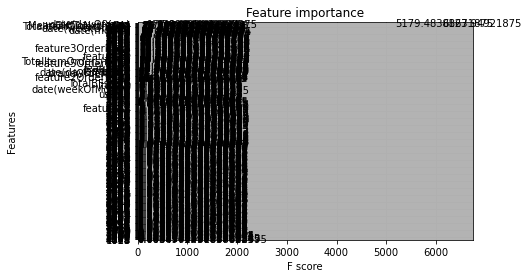

Predicting values...



ValueError: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.

In [17]:
%%time
pred_train, pred_test, X_train, y_train, X_test, y_test = execute_pipeline(train_xgb, df2, [
    '2020-06-01', # start train set
    '2020-10-31', # end train set
    '2020-11-01', # start test set
    '2020-11-30'  # end test set
])

### Evaluation

#### train set

In [18]:
df_eval_train = evaluate_pred(X_train, y_train, pred_train)
df_eval_train.tail(100)

NameError: name 'X_train' is not defined

#### test set

In [19]:
df_eval_test = evaluate_pred(X_test, y_test, pred_test)

NameError: name 'X_test' is not defined

In [12]:
rowcount = len(df_eval_test)
should = len(df_eval_test.loc[(df_eval_test['nextBuyInWeeks(floor)'] != 0)])
is_ = len(df_eval_test.loc[(df_eval_test['nextBuyInWeeks(floor)'] != 0) & (df_eval_test['nextBuyInWeeks(floor)'] == df_eval_test.nextBuyIn_pred)]) 

print(f'row count of set:\t\t\t\t\t {rowcount}')
print(f'rows where label is not 0:\t\t\t\t {should} \t ({should/rowcount*100:.3f} % of all rows in set)')
print(f'rows where label was predicted correctly AND not 0:\t {is_} \t ({is_/should*100:.3f} % of rows where label is not 0)')

row count of set:					 130779
rows where label is not 0:				 15923 	 (12.176 % of all rows in set)
rows where label was predicted correctly AND not 0:	 1905 	 (11.964 % of rows where label is not 0)


In [13]:
rowcount = len(df_eval_test)
should = rowcount
is_ = len(df_eval_test.loc[(df_eval_test['nextBuyInWeeks(floor)'] == df_eval_test.nextBuyIn_pred)]) 

print(f'row count of set:\t\t\t\t {rowcount}')
print(f'rows where label was predicted correctly:\t {is_} \t ({is_/should*100:.3f} % of rows)')

row count of set:				 130779
rows where label was predicted correctly:	 100844 	 (77.110 % of rows)


In [14]:
df_eval_train.loc[(df_eval_train.itemID == 751) ]

,userID,itemID,order,brand,feature_1,feature_2,feature_3,feature_4,feature_5,brandOrderRatio,...,4293,4294,4295,4296,4297,4298,4299,9999,nextBuyInWeeks(floor),nextBuyIn_pred
850,7417,751,1,135,4,0,487,3,175,0.001973,...,0,0,0,0,0,0,0,0,0,0
8839,38607,751,1,135,4,0,487,3,175,0.001973,...,0,0,0,0,0,0,0,0,13,13
25656,22159,751,1,135,4,0,487,3,175,0.001973,...,0,0,0,0,0,0,0,0,0,0
85138,26482,751,1,135,4,0,487,3,175,0.001973,...,0,0,0,0,0,0,0,0,0,0
86889,40291,751,1,135,4,0,487,3,175,0.001973,...,0,0,0,0,0,0,0,0,21,16
129794,44916,751,1,135,4,0,487,3,175,0.001973,...,0,0,0,0,0,0,0,0,0,0
134419,43550,751,1,135,4,0,487,3,175,0.001973,...,0,0,0,0,0,0,0,0,0,0
158307,7083,751,1,135,4,0,487,3,175,0.001973,...,0,0,0,0,0,0,0,0,0,0
168306,18235,751,3,135,4,0,487,3,175,0.001973,...,0,0,0,0,0,0,0,0,0,0
184785,42297,751,1,135,4,0,487,3,175,0.001973,...,0,0,0,0,0,0,0,0,0,0


In [15]:
df_eval_test.loc[(df_eval_test.userID == 69) & (df_eval_test.itemID == 751)]

,userID,itemID,order,brand,feature_1,feature_2,feature_3,feature_4,feature_5,brandOrderRatio,...,4293,4294,4295,4296,4297,4298,4299,9999,nextBuyInWeeks(floor),nextBuyIn_pred
638240,69,751,1,135,4,0,487,3,175,0.001973,...,0,0,0,0,0,0,0,0,4,1


In [ ]:
#df_eval_test.loc[(df_eval_test.userID == 3599) & (df_eval_test.itemID == 26162)]

In [ ]:
#df_eval_test.loc[(df_eval_test.nextBuyInWeeks(floor) == df_eval_test.nextBuyIn_pred) & (df_eval_test.nextBuyInWeeks(floor) != 0)]

---

## Decision Tree

In [ ]:
%%time
#dtc
pred_train, pred_test, X_train, y_train, X_test, y_test = execute_pipeline(train_dtc, df, [
    '2020-06-01', # start train set
    '2020-10-31', # end train set
    '2020-11-01', # start test set
    '2020-11-30'  # end test set
])

### Evaluation

#### train set

In [ ]:
df_eval_train = evaluate_pred(X_train, y_train, pred_train)

#### test set

In [ ]:
df_eval_test = evaluate_pred(X_test, y_test, pred_test)

In [ ]:
rowcount = len(df_eval_test)
should = len(df_eval_test.loc[(df_eval_test.nextBuyInWeeks != 0)])
is_ = len(df_eval_test.loc[(df_eval_test.nextBuyInWeeks != 0) & (df_eval_test.nextBuyInWeeks == df_eval_test.nextBuyIn_pred)]) 

print(f'row count of set:\t\t\t\t\t {rowcount}')
print(f'rows where label is not 0:\t\t\t\t {should} \t ({should/rowcount*100:.3f} % of all rows in set)')
print(f'rows where label was predicted correctly AND not 0:\t {is_} \t ({is_/should*100:.3f} % of rows where label is actually 0)')

## Hyperparameter Tuning

In [ ]:
b = [
    '2020-06-01', # start train set
    '2020-10-31', # end train set
    '2020-11-01', # start test set
    '2020-11-30'  # end test set
    ]
X_train, y_train, X_test, y_test = dt_train_test_split(df, b[0], b[1], b[2], b[3])

In [ ]:
import hyperopt
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

space = {
        'eta': hp.quniform('eta', 0.01, 0.5, 0.01),
        'max_depth': hp.quniform('max_depth', 3, 5, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40, 180, 1),
        'reg_lambda' : hp.uniform('reg_lambda', 0, 1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5, 1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 1000,
        'seed': 0
    }

In [ ]:
def objective(space):
    reg=xgb.XGBRegressor(tree_method='gpu_hist', gpu_id=0,
                    eta = space['eta'],
                    max_depth = int(space['max_depth']), 
                    gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),
                    min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']),
                    n_estimators = space['n_estimators'])
    
    evaluation = [( X_train, y_train), ( X_test, y_test)]
    
    reg.fit(X_train, y_train,
            eval_set=evaluation, eval_metric="rmse",
            early_stopping_rounds=10,verbose=False)
    

    pred = reg.predict(X_test)
    loss = mean_squared_error(y_test, pred)
    #print ("LOSS:", loss)
    return {'loss': loss, 'status': STATUS_OK }

In [ ]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 1000,
                        trials = trials)

In [ ]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

In [ ]:
type(best_hyperparams)

## XGBoost mit optimierten Hyperparametern

In [ ]:
%%time
pred_train, pred_test, X_train, y_train, X_test, y_test = execute_pipeline(train_xgb_bestHyper, df, [
    '2020-06-01', # start train set
    '2020-10-31', # end train set
    '2020-11-01', # start test set
    '2020-11-30'  # end test set
])

### Evaluation

#### train set

In [ ]:
df_eval_train = evaluate_pred(X_train, y_train, pred_train)

#### test set

In [ ]:
df_eval_test = evaluate_pred(X_test, y_test, pred_test)

In [ ]:
rowcount = len(df_eval_test)
should = len(df_eval_test.loc[(df_eval_test.nextBuyInWeeks != 0)])
is_ = len(df_eval_test.loc[(df_eval_test.nextBuyInWeeks != 0) & (df_eval_test.nextBuyInWeeks == df_eval_test.nextBuyIn_pred)]) 

print(f'row count of set:\t\t\t\t\t {rowcount}')
print(f'rows where label is not 0:\t\t\t\t {should} \t ({should/rowcount*100:.3f} % of all rows in set)')
print(f'rows where label was predicted correctly AND not 0:\t {is_} \t ({is_/should*100:.3f} % of rows where label is actually 0)')